# Single point analysis of least-cost paths

Here we pick a single point, in Tasmania, and find the least-cost path to all other points on the island.
It is then visualised, so we can ensure things are making sense.

Most of the time, we'd want to just get the cost of all paths to a point, using the `get_from_point` function, but here we just look at how the algorithm works for a single point.

In [1]:
import meshio
import numpy as np
from multiprocessing import Pool
import time

from ugs import *

%load_ext line_profiler

In [2]:
infile = "australia/data/TAS.vtk"
#infile = "bluemountains/data/blueMountains.vtk"

mesh = meshio.read(infile)

In [3]:
max_distance = 250000  # how far should we go from the initial point?
starting_point = 199   # Pick a point from the TAS.vtk
near_point = 147       # Pick another point, which is relatively close to the starting_point, just for testing

In [4]:
# We need to define a way to calculate cost
def travel_cost(mesh, current, _next):
    # The travel_cost can be any function, including just the distance.
    # Here, we exagerate the elevation difference, to make changing elevation more costly
    if current == _next:
        return 0
    
    z_scaling = 100.
    
    new_current = np.append(mesh.points[current][:2], mesh.point_data['Z'][current] * z_scaling)
    new_next    = np.append(mesh.points[_next][:2],   mesh.point_data['Z'][_next]   * z_scaling)
    
    return int(np.linalg.norm(new_current - new_next))  # return as Int, just for niceness

In [5]:
travel_cost(mesh, starting_point, near_point)  # Test the travel_cost function between two points

31709

In [6]:
distance(mesh, starting_point, near_point)  # Test the distance function between two points

12680

In [7]:
#%lprun -m ugs -f cost_search cost_search(mesh, starting_point, max_distance)

In [8]:
# Do the least-cost path calculations, and get back the data
came_from, cost_so_far = cost_search(mesh, starting_point, travel_cost_function = travel_cost, max_distance = max_distance)

## Data structures

### came_from
`came_from` is a dictionary, where the keys are point IDs, and the value is the point ID of the point it came_from.

In [9]:
# Show some of the came_from data structure
count = 0
num_points_to_show = 80
for point, preceeding_point in came_from.items():
    print(str(point) + "\tcame from\t" + str(preceeding_point))
    if num_points_to_show > 80:
        break
    count +=1

22	came from	473
47	came from	549
54	came from	400
58	came from	390
111	came from	561
116	came from	431
125	came from	601
126	came from	196
127	came from	419
128	came from	130
129	came from	568
130	came from	131
131	came from	1080
132	came from	1201
133	came from	134
134	came from	1229
135	came from	1215
136	came from	138
137	came from	138
138	came from	139
139	came from	140
140	came from	141
141	came from	142
142	came from	143
143	came from	144
144	came from	145
145	came from	146
146	came from	199
147	came from	199
148	came from	147
149	came from	148
150	came from	200
151	came from	150
152	came from	151
153	came from	152
154	came from	153
155	came from	801
156	came from	155
157	came from	156
158	came from	466
159	came from	534
160	came from	159
161	came from	160
162	came from	161
163	came from	162
164	came from	163
165	came from	164
166	came from	165
167	came from	166
168	came from	1095
169	came from	1095
170	came from	1140
171	came from	1127
172	came from	173
173	came from	176
174	ca

You can see above that point `199` "came_from" `None`, since it was the initial point. 

This also means you can pick a point, e.g., `47`, and follow it back until you reach the starting point, AKA, when the `came_from` value is `None`.

In [10]:
# follow a single chain back to the origin point

point = 47                        # choose a start point
while point:                      # while point is not None
    print str(point) + " -> ",
    point = came_from[point]

47 ->  549 ->  451 ->  291 ->  605 ->  383 ->  297 ->  782 ->  243 ->  807 ->  733 ->  146 ->  199 -> 


### cost_so_far

`cost_so_far` is also a dictionary, where the keys are point IDs, and the value is total cost it has taken to reach that point, from the starting point

In [11]:
# the cost to get from the starting point, 199, to the random point 47:
point = 47
print cost_so_far[point]

190886


In [12]:
# Show the progressive cost of going from a point to the starting point
point = 47                        # choose a start point
while point:                      # while point is not None
    print str(cost_so_far[point]) + " -> ",
    point = came_from[point]

190886 ->  181394 ->  168533 ->  147509 ->  134974 ->  121527 ->  106555 ->  96299 ->  79140 ->  69219 ->  60972 ->  30583 ->  0 -> 


## Show a map of all shortest paths

Since all paths have to lead back to the starting point, we can map out each of their paths by finding edge nodes, and then following the `came_from` paths back to the starting point.

In [13]:
# Find all the nodes that are at the edge of the tree
edge_nodes = []

for k in came_from.keys():             # For all the points we've visited,
    if k not in came_from.values():    # Find all the points that haven't been 'came_from'
        edge_nodes.append(k)
        
print edge_nodes

[22, 47, 54, 58, 111, 116, 125, 127, 128, 129, 132, 135, 137, 157, 167, 171, 172, 174, 175, 181, 184, 192, 193, 197, 202, 203, 204, 213, 217, 224, 227, 228, 241, 245, 248, 251, 262, 266, 275, 276, 277, 282, 283, 284, 298, 308, 311, 316, 318, 322, 324, 325, 330, 332, 337, 338, 343, 348, 349, 352, 354, 356, 360, 361, 364, 365, 367, 371, 372, 375, 376, 377, 378, 386, 394, 395, 398, 409, 410, 415, 422, 423, 424, 425, 433, 439, 441, 443, 447, 449, 450, 457, 463, 464, 467, 469, 476, 478, 480, 485, 487, 493, 496, 498, 506, 509, 513, 515, 517, 519, 521, 533, 537, 538, 541, 544, 546, 547, 553, 556, 558, 559, 562, 564, 569, 570, 574, 577, 580, 581, 582, 585, 587, 589, 594, 606, 607, 608, 615, 621, 624, 635, 641, 643, 644, 648, 649, 651, 653, 654, 656, 661, 663, 671, 672, 673, 674, 675, 680, 682, 683, 684, 685, 687, 688, 693, 695, 696, 699, 702, 703, 704, 705, 707, 713, 720, 721, 722, 725, 726, 727, 728, 730, 735, 737, 739, 742, 747, 755, 759, 760, 763, 766, 771, 772, 774, 775, 776, 777, 785, 788

In [14]:
# For each edge node, follow the path back to the starting point, and keep track of the points and costs along the way
paths = []
costs = []
for p in edge_nodes:
    point = p
    cost = 0
    new_points = []
    new_costs = []
    while point:
        new_points.append(mesh.points[point])  # note, the points are being pulled from the VTK, so we get all their info
        new_costs.append(cost_so_far[point])
        point = came_from[point]

    new_points = np.array(new_points)
    new_costs  = np.array(new_costs)
    paths.append(new_points)
    costs.append(new_costs)

In [15]:
# Find the highest cost path
max_cost = max([max(c) for c in costs])
print max_cost

349497


<IPython.core.display.Javascript object>


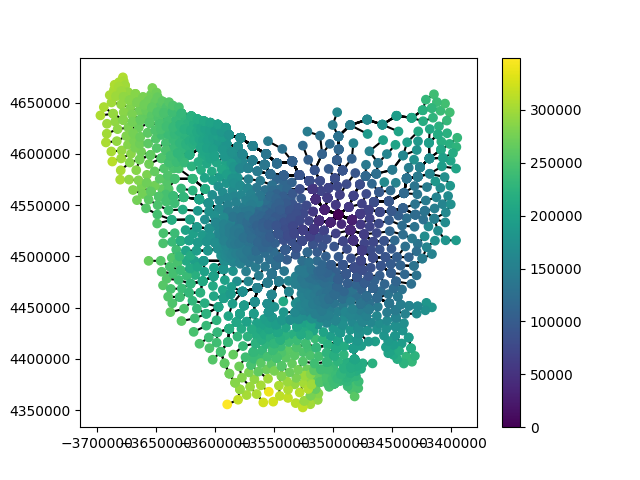

In [16]:
# Visualise all the paths back to the starting point, with colours showing the cost along the way

%matplotlib notebook
import matplotlib.pyplot as plt

norm = plt.Normalize(0, max_cost)
for p, c in zip(paths, costs):    
    plt.plot(p[:,0], p[:,1], c='k', zorder=0)
    plt.scatter(p[:,0], p[:,1], c=c, norm=norm, zorder=1)
    
plt.colorbar()